# Short-term Temperature Model Test

## Import dependencies and data

In [69]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [70]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [71]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [72]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    #('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [73]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
temperatures  TA01_GT10X_GM10X    14
              DC_GT401_GM401      13
              DC_GT301_damped     11
              DC_GT301_outdoor    12
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  1
              vol                  1
time          mod                  1
              doy                  1
dtype: int64





In [74]:
# remove single NAN
data = data.dropna(how='any')

In [75]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                             
flow         TA01_GP101        256307.0  2350.250109  606.496210   
temperatures TA01_GT10X_GM10X  256307.0    20.744780    1.277302   
             DC_GT401_GM401    256307.0    49.457779    3.449043   
             DC_GT301_damped   256307.0    -5.075586    6.692212   
             DC_GT301_outdoor  256307.0    -5.044733    6.653601   
setpoints    TA01_GT10X_GM10X  256307.0    20.661806    0.752603   
sun          gsi               256307.0    29.613519   73.869482   
             vol               256307.0   341.129407  959.522961   
time         mod               256307.0     0.631371    0.306814   
             doy               256307.0     0.316662    0.202923   

                                        min          25%          50%  \
category     sensor_ID                                                  
flow         TA01_GP101        1.761400e+03  1860.000000  2059.000000   
temperatures TA01_GT10X_GM10X  1.170000e+01    19.900000    20.300000   
             DC_GT401_GM401    1.540000e+01    48.700000    50.200000   
             DC_GT301_damped  -2.160000e+01   -10.400000    -3.800000   
             DC_GT301_outdoor -2.090000e+01   -10.300000    -3.700000   
setpoints    TA01_GT10X_GM10X  2.000000e+01    20.000000    20.000000   
sun          gsi               0.000000e+00     0.000000     0.003810   
             vol               0.000000e+00     0.000000     0.000000   
time         mod               0.000000e+00     0.378649     0.697790   
             doy               1.224647e-16     0.128748     0.296713   

                                       75%          max  
category     sensor_ID                                   
flow         TA01_GP101        2738.400000  4206.600000  
temperatures TA01_GT10X_GM10X    21.500000    29.800000  
             DC_GT401_GM401      51.200000    56.200000  
             DC_GT301_damped      0.100000     9.300000  
             DC_GT301_outdoor     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X    21.500000    22.100000  
sun          gsi                 10.347395   491.320000  
             vol                  0.253368  3600.000000  
time         mod                  0.917060     1.000000  
             doy                  0.501242     0.668064

## Process / transform variables 

In [76]:
# remove erroneous setpoints data
data = data[data.setpoints.TA01_GT10X_GM10X != 0.0]

# # set temp to adjusted for setpoint
# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
#                                                 - (data.setpoints.TA01_GT10X_GM10X - 20.0)

# ## Use temperature Diff. w.r.t. setpoint
# #data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
# #    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Transform setpoints variable to instead account for difference w.r.t 20 deg C
data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X - 20.0

In [77]:
# remove "OUTLIERS" from DC-TEMP
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll

In [78]:
# remove "OUTLIERS" from DC-FLOW
data[('flow', 'TA01_GP101')] = data.flow.TA01_GP101.apply(lambda val: max(1800, val))

# squeeze  flow
maxVal = data.flow.TA01_GP101.max()
minVal = data.flow.TA01_GP101.min()
data[('flow', 'TA01_GP101')] = data.flow.TA01_GP101.apply(lambda val: (val - minVal) / (maxVal - minVal))

In [79]:
# # make flow OUT negative
# data[('flow', 'FF01_GP101')] = - data.flow.FF01_GP101

In [80]:
# perform FFT 
fourier = np.fft.rfft( data.temperatures.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 100 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
data[('temperatures', 'DC_GT401_GM401_fft')].iloc[1:] = filtered

### Plot pairwise correlation matrix

In [81]:
# corr = data.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))

# plt.figure(figsize=(12, 6))
# sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

# plt.xticks(rotation=45)
# plt.title('Pairwise correlation plot')
# plt.show()

# # delete correlation data
# del corr

## Preparing data

In [82]:
t_steps = 20  # 10-min predictions
n_steps = 30  # 15 minute backwards look

train_frac = 0.8

### Data selection and whitening

In [83]:
# # save temp mean & std

# temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
# temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [84]:
# # normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [85]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    #('flow', 'FF01_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401_fft'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'setpoint_diff'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter data
data = data[model_vars]

In [86]:
# define target
# targets = data.pop(('temperatures', 'TA01_GT10X_GM10X')).shift(periods=-t_steps)  # 0-minute forward
targets = data[('temperatures', 'TA01_GT10X_GM10X')].copy().shift(periods=-t_steps)

# remove NaNs
targets = targets.iloc[:-t_steps]
data = data.iloc[:-t_steps]

### Create sequences

In [87]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['minute'] = data.index.get_level_values(3).values
    data['date_flag'] = data.minute - data.minute.shift(periods=n_steps) > n_steps / 2

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['minute'], data['date_flag']
    
    return flagged_idx

In [88]:
# get all n_step-sequences from data series
sequences = np.stack([
    data.values[i:i+n_steps, :] for i in range(len(data) - n_steps)
]) 

# get flagged sequences
flags = date_flagger(data, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask]

# get targets, delete mask
targets = targets.values[n_steps:][mask]

In [89]:
# delete data 
del data

# save sequential seqs, targets for testing
sequences, test_seqs  = sequences[:-8640], sequences[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

### Shuffle and split dataset

In [22]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
sequences = np.squeeze(sequences[idxs])
targets = np.squeeze(targets[idxs])


In [23]:
# split data
train_n = int(len(targets) * train_frac)
#test_n = len(targets) - train_n

X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [24]:
# delete vars
del sequences, targets

## Define model

In [25]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
#         units=16,
        activation='tanh',
        return_sequences=True,
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
#         units=16,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    #layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    layers.Dense(
        units=256,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    layers.Dense(
        units=256,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [26]:
# lr = 0.005
lr = 0.001
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 10)           40        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 30, 32)            5504      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                             

In [27]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/20
1238/1238 [==============================] - 112s 87ms/step - loss: 0.9209 - val_loss: 0.4844
Epoch 2/20
1238/1238 [==============================] - 88s 71ms/step - loss: 0.2323 - val_loss: 0.3037
Epoch 3/20
1238/1238 [==============================] - 101s 81ms/step - loss: 0.1798 - val_loss: 0.1967
Epoch 4/20
1238/1238 [==============================] - 107s 86ms/step - loss: 0.1578 - val_loss: 0.1613
Epoch 5/20
1238/1238 [==============================] - 93s 75ms/step - loss: 0.1404 - val_loss: 0.1656
Epoch 6/20
1238/1238 [==============================] - 93s 75ms/step - loss: 0.1290 - val_loss: 0.1275
Epoch 7/20
1238/1238 [==============================] - 80s 65ms/step - loss: 0.1215 - val_loss: 0.1087
Epoch 8/20
1238/1238 [==============================] - 92s 74ms/step - loss: 0.1181 - val_loss: 0.0985
Epoch 9/20
1238/1238 [==============================] - 93s 75ms/step - loss: 0.1148 - val_loss: 0.1105
Epoch 10/20
1238/1238 [==============================] - 87s 

In [28]:
# model_name = 'temp_model_v7'
# model.save(save_path + model_name)

In [29]:
preds = model.predict(X_test)
vis_preds = model.predict(test_seqs)

270/270 [==============================] - 2s 6ms/step


In [30]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae# * temp_std

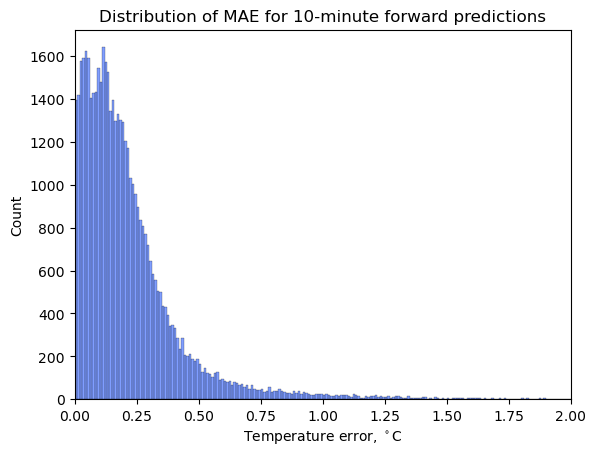

In [31]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 10-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Temperature error, $^\circ$C')

#plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

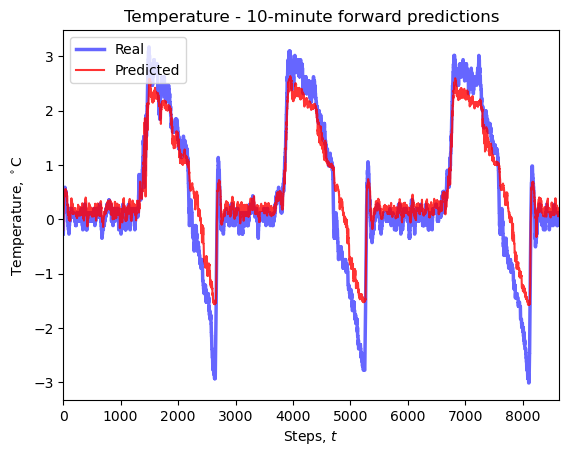

In [33]:
plt.plot(
    np.squeeze(test_targets),# * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    vis_preds,# * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Temperature, $^\circ$C')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('Temperature - 10-minute forward predictions')

#plt.ylim(15, 30)
plt.xlim(0, len(vis_preds))

#plt.savefig(plot_path + 'temp_preds_10min.png', bbox_inches='tight', dpi=200)

plt.show()

In [321]:
# ex_seqs[0, 0, :]

In [113]:
# ex_seqs = test_seqs.copy()
# ex_seqs[:, :, 0] = -4
# #ex_seqs[:, :, 1] = 300
# #ex_seqs[:, :, 2] = 20
# ex_preds = model.predict(ex_seqs[:1, :, :])

In [114]:
# valList = []
# for i in range(-4000, 4000):
#     ex_seqs[:1, :, 0] = np.random.normal(loc=i, scale=500, size=30)
#     #pred = model.predict(ex_seqs, verbose=0)
#     valList.append(ex_seqs[:1, :, :].copy())
# vals = np.vstack(valList)
# preds = model.predict(np.vstack(valList))

In [116]:
seqs = test_seqs.copy()
predList = []
for idx, seq in enumerate(seqs):
    if idx % 100 == 0:
        print('Sequence {}'.format(idx))
    
    newVal = seq[:, 0] + np.random.normal(loc=2.0, scale=0.5)
    seq[:, 0] = newVal
    pred = model.predict(seq[np.newaxis, ...], verbose=0)[0, 0]
    predList.append(pred)
    for i in range(1, 31):
        seqs[i:i+1, -i, 2] = pred # update temperature values


Sequence 0
Sequence 100
Sequence 200
Sequence 300
Sequence 400
Sequence 500
Sequence 600
Sequence 700
Sequence 800
Sequence 900
Sequence 1000
Sequence 1100
Sequence 1200
Sequence 1300
Sequence 1400
Sequence 1500
Sequence 1600
Sequence 1700
Sequence 1800
Sequence 1900
Sequence 2000
Sequence 2100
Sequence 2200
Sequence 2300
Sequence 2400
Sequence 2500
Sequence 2600
Sequence 2700
Sequence 2800
Sequence 2900
Sequence 3000
Sequence 3100
Sequence 3200
Sequence 3300
Sequence 3400
Sequence 3500
Sequence 3600
Sequence 3700
Sequence 3800
Sequence 3900
Sequence 4000
Sequence 4100
Sequence 4200
Sequence 4300
Sequence 4400


KeyboardInterrupt: 

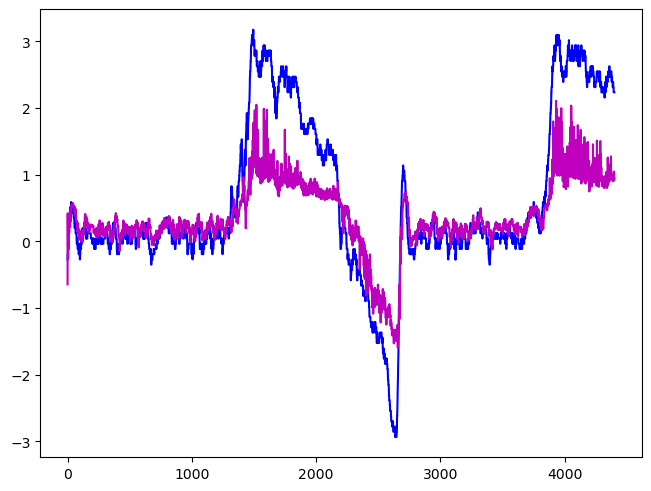

In [117]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.squeeze(test_targets)[:4400], c='b')
ax.plot(predList[:4400], c='m')

# ax_sec = ax.twinx()

# ax_sec.plot(test_seqs[-8000:, 0, 0], c='r', linewidth=1.5, alpha=0.8)
# ax_sec.set_ylim(0, 5000)
# #plt.plot(test_seqs[-4000:, 0, 0])

plt.show()

In [103]:
print(test_seqs[:, :, 0])

[[-0.8625151  -0.86185554 -0.87537653 ... -0.05109078  0.02047153
   0.09681566]
 [-0.86185554 -0.87537653 -0.9025834  ...  0.02047153  0.09681566
   0.13507017]
 [-0.87537653 -0.9025834  -0.85113768 ...  0.09681566  0.13507017
   0.17184067]
 ...
 [ 1.42912789  1.43803195  1.44710091 ...  1.5574124   1.52179614
   1.57043872]
 [ 1.43803195  1.44710091  1.44479245 ...  1.52179614  1.57043872
   1.5592262 ]
 [ 1.44710091  1.44479245  1.44710091 ...  1.57043872  1.5592262
   1.54587009]]


In [315]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.97292608],
       [0.97292608, 1.        ]])

In [316]:
np.corrcoef(np.squeeze(preds), Y_test)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 8000 and the array at index 1 has size 49507